# Dependencies & Dataset Loading

Imports & Dependencies

In [ ]:
!pip install gensim
!pip install joblib
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, SimpleRNN, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import gensim.downloader as api
from gensim.models import Word2Vec

Dataset Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Question Answer Classification Dataset 2[Training].csv'
df = pd.read_csv(path)

path2 = '/content/drive/MyDrive/[Updated] Question Answer Classification Dataset[Test].csv'
df_test = pd.read_csv(path2)

# EDA

In [ ]:
df.head()

QA Text                  Class
0  name 206 bone human body 206 bone human bodynn...  Science & Mathematics
1  tell university name distance mphil food nutri...  Education & Reference
2  suggestion advice tracking someone owes money ...  Politics & Government
3  find system poem victim written guitarist band...  Entertainment & Music
4  first tour match india south africa telecast c...                 Sports

In [ ]:
df.shape

(279999, 2)

In [ ]:
df.dtypes

QA Text    object
Class      object
dtype: object

Class distribution

In [ ]:
df['Class'].value_counts()

Class
Education & Reference     28177
Sports                    28127
Business & Finance        28085
Society & Culture         28081
Family & Relationships    28049
Politics & Government     27988
Computers & Internet      27962
Science & Mathematics     27870
Health                    27863
Entertainment & Music     27797
Name: count, dtype: int64

Plotting it

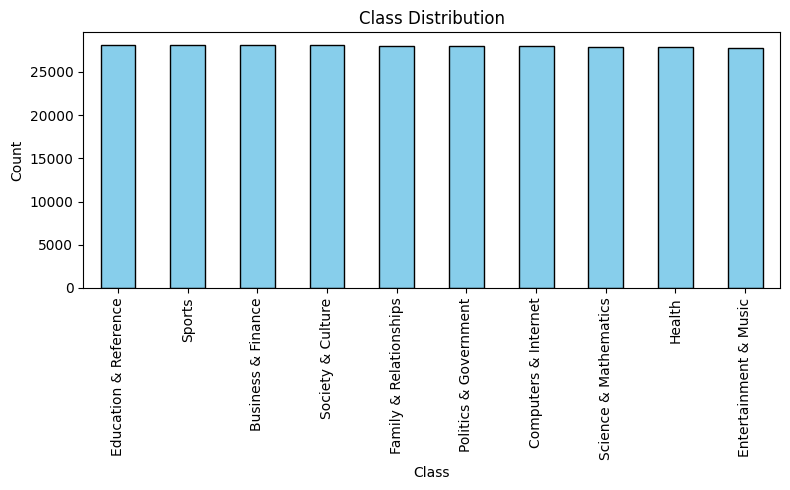

In [ ]:
import matplotlib.pyplot as plt

class_counts = df['Class'].value_counts()

plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# We can see that this dataset is balanced. No need to do downsampling or upsampling.

Wordcloud


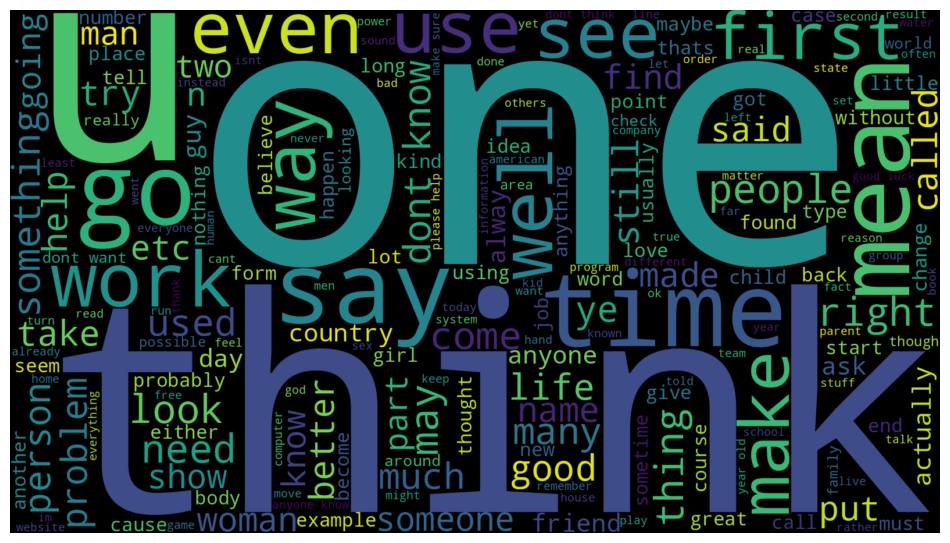

In [25]:
from wordcloud import WordCloud

text = " ".join(df["QA Text"].astype(str))  #string of all space-split words

wordcloud = WordCloud(width=1600, height=900, background_color='black').generate(text)

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [26]:
df.tail(5)

QA Text  \
279994  anyone know good neurolgist seattle area belie...   
279995  really need partner since character developeme...   
279996  girl like spanked soft hardor realy hard im gu...   
279997  find given graph cyclic may good theory topic ...   
279998  place watch england getting beat world cup fin...   

                         Class  
279994                  Health  
279995       Society & Culture  
279996  Family & Relationships  
279997    Computers & Internet  
279998                  Sports

# Preprocessing



Imports

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = list(stopwords.words('english'))
stop_words.append("title")
stop_words.append("question")
stop_words.append("content")
stop_words.append("best")
stop_words.append("answer")

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Pre-processing

In [ ]:
#Training Data

#Converting to lowercase
df['QA Text'] = df['QA Text'].apply(lambda x: x.lower())

#Remove punctuation
df['QA Text'] = df['QA Text'].str.replace('[^\w\s]', '', regex=True)

#Splitting text into individual words
df['QA Text'] = df['QA Text'].apply(lambda x: x.split())

#Remove stopwords
df['QA Text'] = df['QA Text'].apply(lambda words: [word for word in words if word not in stop_words])

#Apply WordNetLemmatizer to each word
df['QA Text'] = df['QA Text'].apply(lambda words: [lemmatizer.lemmatize(word) for word in words])

#Join words back into a single string
df['QA Text'] = df['QA Text'].apply(lambda words: " ".join(words))

In [ ]:
#Test Data

#Converting to lowercase
df_test['QA Text'] = df_test['QA Text'].apply(lambda x: x.lower())

#Remove punctuation
df_test['QA Text'] = df_test['QA Text'].str.replace('[^\w\s]', '', regex=True)

#Splitting text into individual words
df_test['QA Text'] = df_test['QA Text'].apply(lambda x: x.split())

#Remove stopwords
df_test['QA Text'] = df_test['QA Text'].apply(lambda words: [word for word in words if word not in stop_words])

#Apply WordNetLemmatizer to each word
df_test['QA Text'] = df_test['QA Text'].apply(lambda words: [lemmatizer.lemmatize(word) for word in words])

#Join words back into a single string
df_test['QA Text'] = df_test['QA Text'].apply(lambda words: " ".join(words))

In [ ]:
df.head()

QA Text                  Class
0  name 206 bone human body 206 bone human bodynn...  Science & Mathematics
1  tell university name distance mphil food nutri...  Education & Reference
2  suggestion advice tracking someone owes money ...  Politics & Government
3  find system poem victim written guitarist band...  Entertainment & Music
4  first tour match india south africa telecast c...                 Sports

In [ ]:
df_test.head()

QA Text                  Class
0  zebra stripe purpose stripe serve zebra wild l...  Science & Mathematics
1                 itsy bitsy sipder climb waterspout  Education & Reference
2  difference bachelor master degree one differen...  Education & Reference
3  woman get pm premenstrual syndrome pm group sy...                 Health
4  coworker guilty unsanitary hygiene would right...                 Health

Training Preparation

In [ ]:
# Extract features and target
X = df['QA Text']  # Preprocessed text data
y = df['Class']    # Target labels

X_test = df_test['QA Text']
y_test = df_test['Class']

# Encode string labels to numeric values for sklearn models
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_test_encoded = label_encoder.transform(y_test)

# Split data into train/validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2,
                                                  random_state=42, stratify=y_encoded)


Global Results

In [ ]:
import os

# Initialize results file at the beginning (when dataset is loaded)
results_file = 'model_results.pkl'

if os.path.exists(results_file):
    results = joblib.load(results_file)
    print(f"Loaded existing results with {len(results)} entries")
else:
    results = []
    joblib.dump(results, results_file)
    print("Created new results file")

Loaded existing results with 20 entries


Global Evaluation Function

In [ ]:
def evaluate_model(model, X_test, y_test, model_name, feature_type, vectorizer=None, tokenizer=None, is_neural=False):
    """
    Unified evaluation function for both ML and NN models
    """
    if is_neural:
        # Handle neural network models
        if tokenizer is not None:
            # For sequence-based NN models
            X_test_seq = tokenizer.texts_to_sequences(X_test)
            X_test_transformed = pad_sequences(X_test_seq, maxlen=100, padding='post', truncating='post')
        elif vectorizer is not None:
            # For BoW/TF-IDF NN models
            X_test_transformed = vectorizer.transform(X_test).toarray()
        else:
            X_test_transformed = X_test

        # Get probability predictions and convert to class predictions
        y_pred_prob = model.predict(X_test_transformed, verbose=0)
        y_pred = np.argmax(y_pred_prob, axis=1)

        # y_test is already encoded for NN models
        y_true = y_test

    else:
        # Handle traditional ML models
        if vectorizer is not None:
            X_test_transformed = vectorizer.transform(X_test)
        else:
            X_test_transformed = X_test

        y_pred = model.predict(X_test_transformed)
        y_true = y_test

    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    # Print detailed results
    print(f"{model_name} with {feature_type}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"F1-Score (Weighted): {f1_weighted:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    # Store results and save to joblib file
    result_entry = {
        'model': model_name,
        'features': feature_type,
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'timestamp': pd.Timestamp.now()
    }

    # Load existing results, append new result, and save
    results = joblib.load(results_file)
    results.append(result_entry)
    joblib.dump(results, results_file)
    print(f"Results saved to {results_file}")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name} with {feature_type}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Machine Learning Models

##BoW Implementations

In [ ]:
# ngram_range=(1,2): includes unigrams and bigrams for better context
bow_vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2))

# Fit vectorizer on training data and transform both train/validation sets
X_train_bow = bow_vectorizer.fit_transform(X_train)  # Fit and transform training data
X_val_bow = bow_vectorizer.transform(X_val)          # Transform validation data only

print(f"BoW Feature Matrix Shape: {X_train_bow.shape}")

BoW Feature Matrix Shape: (223999, 10000)


BoW + Random Forest

Training BoW + Random Forest...
Random Forest with BoW:
Accuracy: 0.5480
F1-Score (Macro): 0.5473
F1-Score (Weighted): 0.5472
Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.58      0.34      0.43      6000
  Computers & Internet       0.68      0.78      0.73      6000
 Education & Reference       0.57      0.26      0.36      6000
 Entertainment & Music       0.73      0.38      0.49      6000
Family & Relationships       0.52      0.73      0.61      5999
                Health       0.67      0.59      0.63      6000
 Politics & Government       0.63      0.64      0.63      6000
 Science & Mathematics       0.29      0.72      0.41      6000
     Society & Culture       0.59      0.41      0.48      6000
                Sports       0.78      0.63      0.70      6000

              accuracy                           0.55     59999
             macro avg       0.60      0.55      0.55     59999
          weighte

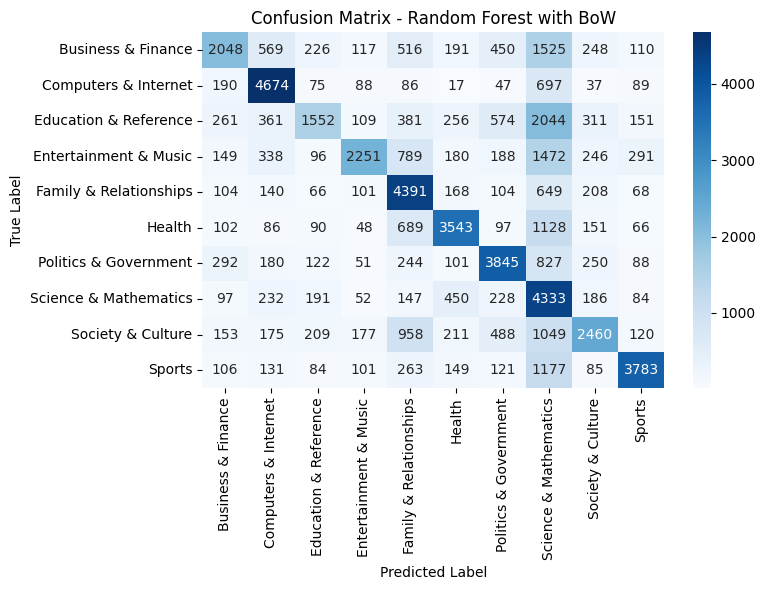

In [ ]:
print("Training BoW + Random Forest...")
rf_bow = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
rf_bow.fit(X_train_bow, y_train)
# Updated evaluation call
evaluate_model(rf_bow, X_test, y_test_encoded, 'Random Forest', 'BoW', bow_vectorizer)

BoW + Logistic Regression

Training BoW + Logistic Regression...
Logistic Regression with BoW:
Accuracy: 0.6359
F1-Score (Macro): 0.6340
F1-Score (Weighted): 0.6340
Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.47      0.45      0.46      6000
  Computers & Internet       0.78      0.82      0.80      6000
 Education & Reference       0.46      0.44      0.45      6000
 Entertainment & Music       0.59      0.64      0.62      6000
Family & Relationships       0.66      0.69      0.67      5999
                Health       0.71      0.71      0.71      6000
 Politics & Government       0.71      0.68      0.69      6000
 Science & Mathematics       0.62      0.64      0.63      6000
     Society & Culture       0.52      0.48      0.50      6000
                Sports       0.80      0.82      0.81      6000

              accuracy                           0.64     59999
             macro avg       0.63      0.64      0.63     59999
     

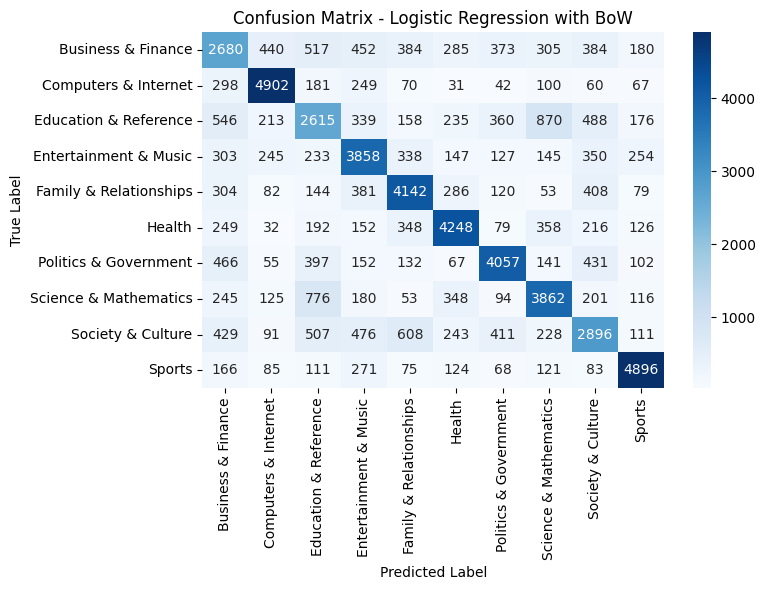

In [ ]:
print("Training BoW + Logistic Regression...")
lr_bow = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
lr_bow.fit(X_train_bow, y_train)
# Updated evaluation call
evaluate_model(lr_bow, X_test, y_test_encoded, 'Logistic Regression', 'BoW', bow_vectorizer)

BoW + Naive Bayes

Training BoW + Naive Bayes...
Naive Bayes with BoW:
Accuracy: 0.6706
F1-Score (Macro): 0.6679
F1-Score (Weighted): 0.6679
Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.56      0.50      0.53      6000
  Computers & Internet       0.79      0.85      0.82      6000
 Education & Reference       0.54      0.45      0.49      6000
 Entertainment & Music       0.58      0.67      0.62      6000
Family & Relationships       0.60      0.78      0.68      5999
                Health       0.73      0.76      0.74      6000
 Politics & Government       0.75      0.70      0.73      6000
 Science & Mathematics       0.71      0.70      0.71      6000
     Society & Culture       0.59      0.52      0.55      6000
                Sports       0.85      0.79      0.82      6000

              accuracy                           0.67     59999
             macro avg       0.67      0.67      0.67     59999
          weighted av

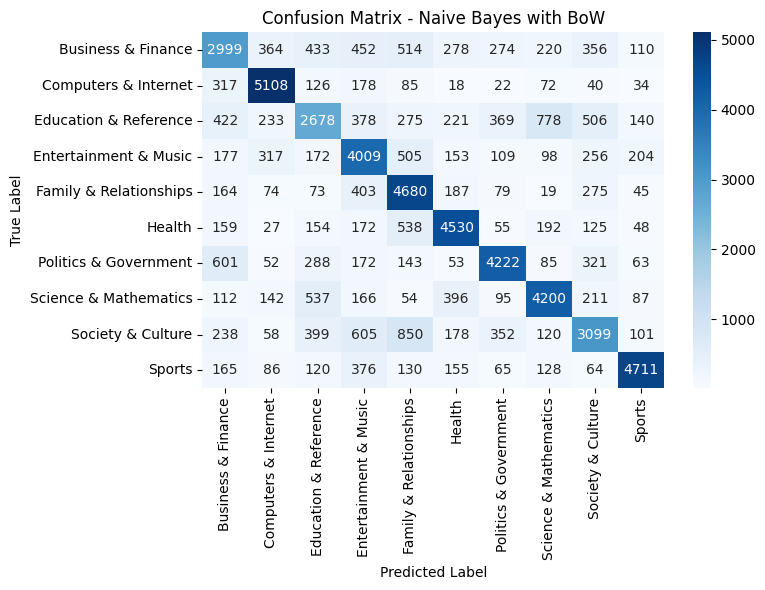

In [ ]:
print("Training BoW + Naive Bayes...")
nb_bow = MultinomialNB(alpha=0.1)
nb_bow.fit(X_train_bow, y_train)
# Updated evaluation call
evaluate_model(nb_bow, X_test, y_test_encoded, 'Naive Bayes', 'BoW', bow_vectorizer)

## TF-IDF Implementations

In [ ]:
# ngram_range=(1,2): unigrams and bigrams
# max_df=0.95: ignore terms that appear in more than 95% of documents
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), max_df=0.95)

# Transform text to TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

print(f"TF-IDF Feature Matrix Shape: {X_train_tfidf.shape}")

TF-IDF Feature Matrix Shape: (223999, 10000)


TF-IDF + Random Forest

Training TF-IDF + Random Forest...
Random Forest with TF-IDF:
Accuracy: 0.5505
F1-Score (Macro): 0.5488
F1-Score (Weighted): 0.5488
Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.59      0.35      0.44      6000
  Computers & Internet       0.69      0.77      0.73      6000
 Education & Reference       0.56      0.26      0.36      6000
 Entertainment & Music       0.66      0.40      0.50      6000
Family & Relationships       0.52      0.74      0.61      5999
                Health       0.67      0.59      0.63      6000
 Politics & Government       0.63      0.64      0.63      6000
 Science & Mathematics       0.30      0.72      0.43      6000
     Society & Culture       0.58      0.41      0.48      6000
                Sports       0.76      0.63      0.69      6000

              accuracy                           0.55     59999
             macro avg       0.60      0.55      0.55     59999
          w

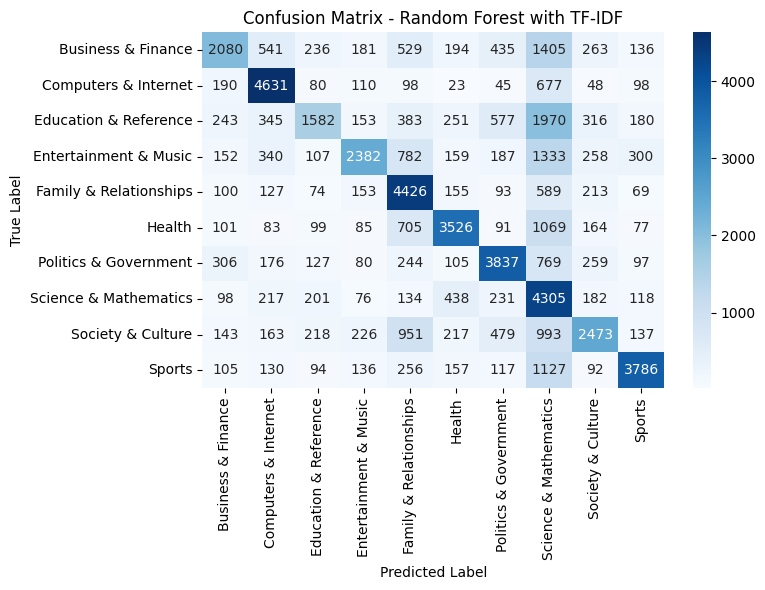

In [ ]:
print("Training TF-IDF + Random Forest...")
rf_tfidf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
rf_tfidf.fit(X_train_tfidf, y_train)
# Updated evaluation call
evaluate_model(rf_tfidf, X_test, y_test_encoded, 'Random Forest', 'TF-IDF', tfidf_vectorizer)

TF-IDF + Logistic Regression

Training TF-IDF + Logistic Regression...
Logistic Regression with TF-IDF:
Accuracy: 0.6894
F1-Score (Macro): 0.6871
F1-Score (Weighted): 0.6871
Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.56      0.50      0.53      6000
  Computers & Internet       0.82      0.85      0.83      6000
 Education & Reference       0.53      0.49      0.51      6000
 Entertainment & Music       0.65      0.67      0.66      6000
Family & Relationships       0.69      0.75      0.72      5999
                Health       0.74      0.77      0.76      6000
 Politics & Government       0.75      0.73      0.74      6000
 Science & Mathematics       0.69      0.73      0.71      6000
     Society & Culture       0.58      0.55      0.57      6000
                Sports       0.85      0.84      0.84      6000

              accuracy                           0.69     59999
             macro avg       0.69      0.69      0.69     59999

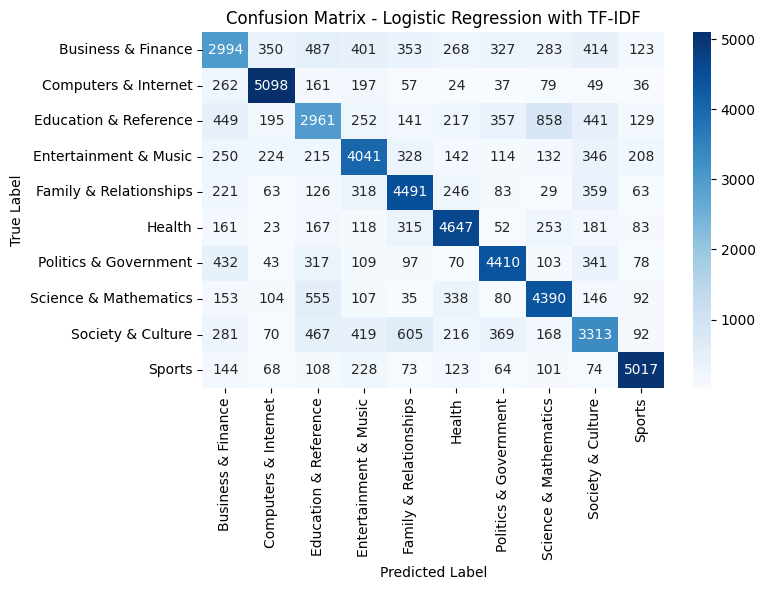

In [ ]:
print("Training TF-IDF + Logistic Regression...")
lr_tfidf = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
lr_tfidf.fit(X_train_tfidf, y_train)
# Updated evaluation call
evaluate_model(lr_tfidf, X_test, y_test_encoded, 'Logistic Regression', 'TF-IDF', tfidf_vectorizer)

TF-IDF + Naive Bayes

Training TF-IDF + Naive Bayes...
Naive Bayes with TF-IDF:
Accuracy: 0.6767
F1-Score (Macro): 0.6738
F1-Score (Weighted): 0.6738
Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.55      0.50      0.53      6000
  Computers & Internet       0.80      0.85      0.82      6000
 Education & Reference       0.55      0.45      0.50      6000
 Entertainment & Music       0.63      0.65      0.64      6000
Family & Relationships       0.62      0.78      0.69      5999
                Health       0.73      0.77      0.75      6000
 Politics & Government       0.74      0.72      0.73      6000
 Science & Mathematics       0.70      0.72      0.71      6000
     Society & Culture       0.58      0.53      0.56      6000
                Sports       0.85      0.79      0.82      6000

              accuracy                           0.68     59999
             macro avg       0.67      0.68      0.67     59999
          weigh

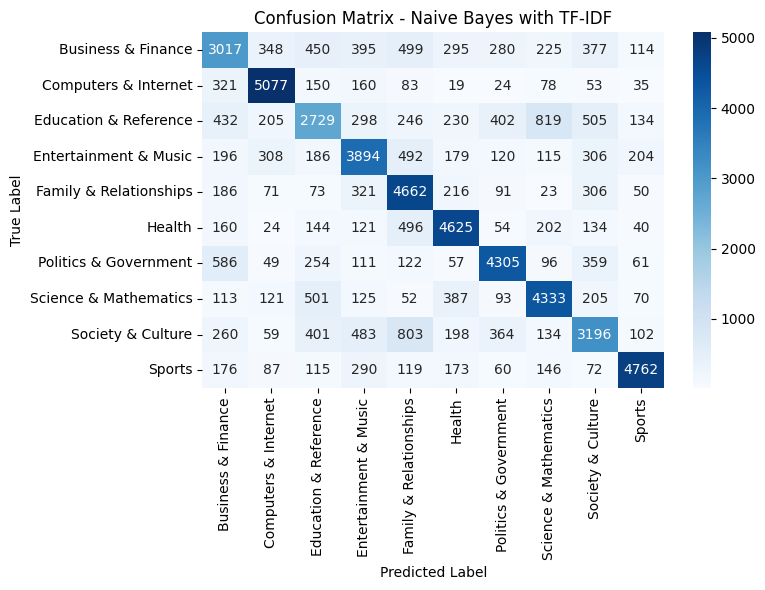

In [ ]:
print("Training TF-IDF + Naive Bayes...")
nb_tfidf = MultinomialNB(alpha=0.1)
nb_tfidf.fit(X_train_tfidf, y_train)
# Updated evaluation call
evaluate_model(nb_tfidf, X_test, y_test_encoded, 'Naive Bayes', 'TF-IDF', tfidf_vectorizer)

# Neural Network Models


## Setup

In [ ]:
print("Setting up neural network models...")

# Create tokenizer for sequence-based models
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Convert labels to categorical for neural networks
num_classes = len(np.unique(y_encoded))
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print(f"Vocabulary Size: {vocab_size}")
print(f"Number of Classes: {num_classes}")
print(f"Sequence Length: {max_length}")

Setting up neural network models...
Vocabulary Size: 631262
Number of Classes: 10
Sequence Length: 100


## BoW and TF-IDF DNNs

### BoW + Deep Neural Network

Training BoW + Deep Neural Network...
BoW Feature Matrix Shape: (223999, 1000)
Epoch 1/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.5241 - loss: 1.5301 - val_accuracy: 0.6069 - val_loss: 1.2303
Epoch 2/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.6028 - loss: 1.2460 - val_accuracy: 0.6099 - val_loss: 1.2132
Epoch 3/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.6090 - loss: 1.2168 - val_accuracy: 0.6120 - val_loss: 1.2078
Epoch 4/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6142 - loss: 1.1939 - val_accuracy: 0.6126 - val_loss: 1.2044
Epoch 5/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.6173 - loss: 1.1832 - val_accuracy: 0.6103 - val_loss: 1.2050
Epoch 6/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.6200 - loss: 1.1761 - val_accuracy: 0.6114 - val_loss: 1.2082
Epoch 7/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.6201 - loss: 1.1718 - val_accuracy: 0.6114 - val_loss: 1.2091
Epoc

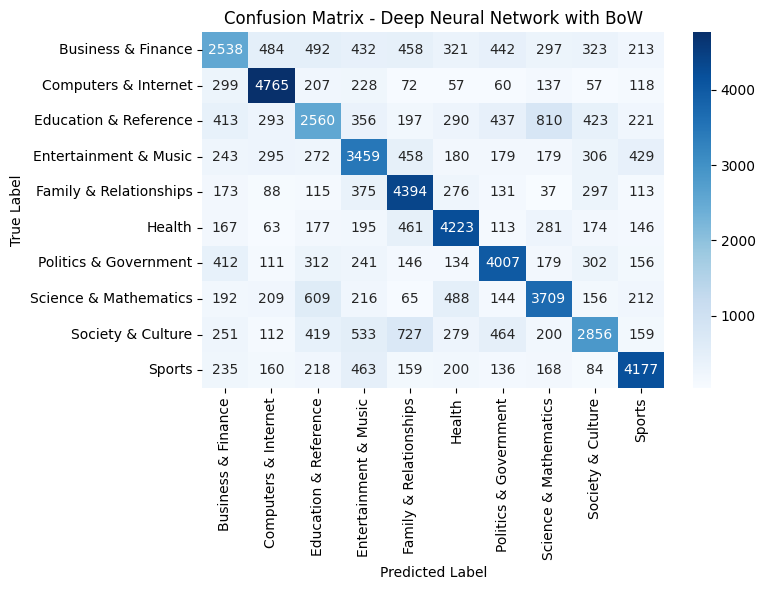

In [ ]:
print("Training BoW + Deep Neural Network...")

# Create BoW vectorizer with 1000 features
bow_vectorizer_nn = CountVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_bow_nn = bow_vectorizer_nn.fit_transform(X_train).toarray()
X_val_bow_nn = bow_vectorizer_nn.transform(X_val).toarray()

print(f"BoW Feature Matrix Shape: {X_train_bow_nn.shape}")

# Build BoW DNN model
model_bow_dnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_bow_nn.shape[1],)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_bow_dnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history_bow_dnn = model_bow_dnn.fit(
    X_train_bow_nn, y_train_cat,
    validation_data=(X_val_bow_nn, y_val_cat),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on test data using unified function
evaluate_model(model_bow_dnn, X_test, y_test_encoded, 'Deep Neural Network', 'BoW',
               vectorizer=bow_vectorizer_nn, is_neural=True)

### TF-IDF + Deep Neural Network

Training TF-IDF + Deep Neural Network...
TF-IDF Feature Matrix Shape: (223999, 1000)
Epoch 1/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.5237 - loss: 1.5479 - val_accuracy: 0.6094 - val_loss: 1.2042
Epoch 2/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6084 - loss: 1.2215 - val_accuracy: 0.6114 - val_loss: 1.1909
Epoch 3/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6137 - loss: 1.1985 - val_accuracy: 0.6132 - val_loss: 1.1869
Epoch 4/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6190 - loss: 1.1810 - val_accuracy: 0.6142 - val_loss: 1.1836
Epoch 5/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6217 - loss: 1.1691 - val_accuracy: 0.6149 - val_loss: 1.1813
Epoch 6/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.6240 - loss: 1.1632 - val_accuracy: 0.6155 - val_loss: 1.1812
Epoch 7/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.6266 - loss: 1.1526 - val_accuracy: 0.6144 - val_loss: 1.181

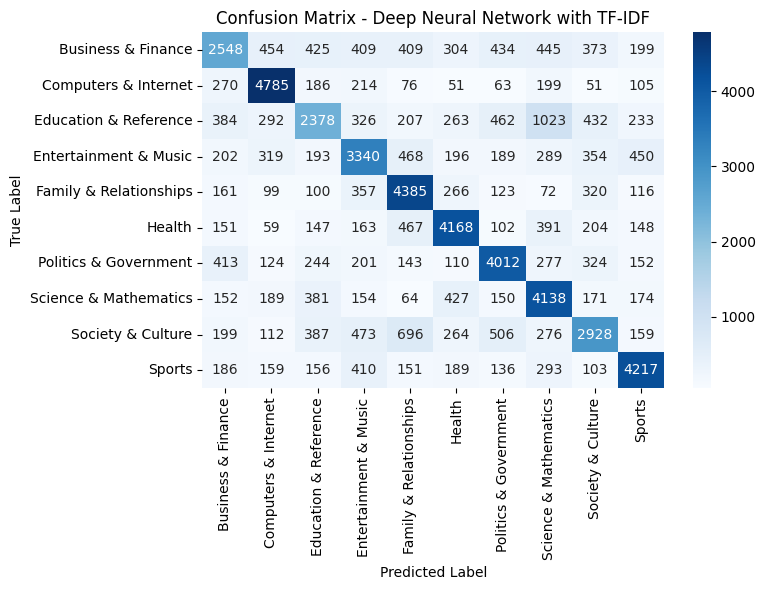

In [ ]:
print("Training TF-IDF + Deep Neural Network...")

# Create TF-IDF vectorizer with 1000 features
tfidf_vectorizer_nn = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), max_df=0.95)
X_train_tfidf_nn = tfidf_vectorizer_nn.fit_transform(X_train).toarray()
X_val_tfidf_nn = tfidf_vectorizer_nn.transform(X_val).toarray()

print(f"TF-IDF Feature Matrix Shape: {X_train_tfidf_nn.shape}")

# Build TF-IDF DNN model
model_tfidf_dnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_tfidf_nn.shape[1],)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_tfidf_dnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history_tfidf_dnn = model_tfidf_dnn.fit(
    X_train_tfidf_nn, y_train_cat,
    validation_data=(X_val_tfidf_nn, y_val_cat),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on test data using unified function
evaluate_model(model_tfidf_dnn, X_test, y_test_encoded, 'Deep Neural Network', 'TF-IDF',
               vectorizer=tfidf_vectorizer_nn, is_neural=True)

## GloVe Implementations

In [ ]:
print("Loading GloVe embeddings...")

glove_vectors = api.load('glove-wiki-gigaword-100')

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill embedding matrix with GloVe vectors for words in our vocabulary
for word, i in tokenizer.word_index.items():
    if word in glove_vectors:
        embedding_matrix[i] = glove_vectors[word]

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Words found in GloVe: {np.sum(np.any(embedding_matrix != 0, axis=1))}/{vocab_size}")

Loading GloVe embeddings...
[==================================================] 100.0% 128.1/128.1MB downloaded
Embedding matrix shape: (631262, 100)
Words found in GloVe: 98316/631262


### GloVe + Deep Neural Network

Training GloVe + Deep Neural Network...
Epoch 1/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.4198 - loss: 1.8027 - val_accuracy: 0.5474 - val_loss: 1.4149
Epoch 2/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.5331 - loss: 1.4512 - val_accuracy: 0.5594 - val_loss: 1.3730
Epoch 3/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5435 - loss: 1.4171 - val_accuracy: 0.5651 - val_loss: 1.3553
Epoch 4/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.5467 - loss: 1.4034 - val_accuracy: 0.5672 - val_loss: 1.3450
Epoch 5/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5517 - loss: 1.3907 - val_accuracy: 0.5650 - val_loss: 1.3447
Epoch 6/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.5547 - loss: 1.3856 - val_accuracy: 0.5695 - val_loss: 1.3344
Epoch 7/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5558 - loss: 1.3790 - val_accuracy: 0.5711 - val_loss: 1.3348
Epoch 8/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 1

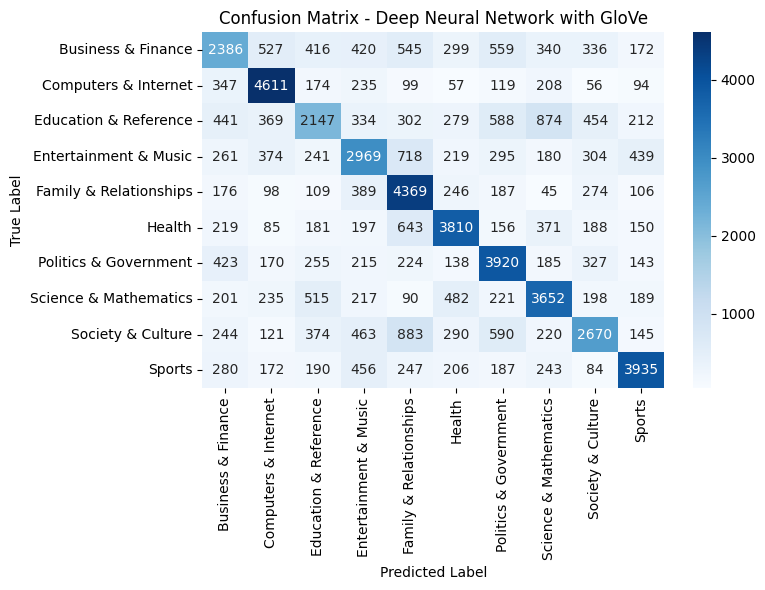

In [ ]:
print("Training GloVe + Deep Neural Network...")

model_glove_dnn = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_glove_dnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_glove_dnn = model_glove_dnn.fit(
    X_train_padded, y_train_cat,
    validation_data=(X_val_padded, y_val_cat),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Updated evaluation call
evaluate_model(model_glove_dnn, X_test, y_test_encoded, 'Deep Neural Network', 'GloVe',
               tokenizer=tokenizer, is_neural=True)

### GloVe + SimpleRNN

Training GloVe + SimpleRNN...
Epoch 1/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 140s 39ms/step - accuracy: 0.0989 - loss: 2.3170 - val_accuracy: 0.1043 - val_loss: 2.2993
Epoch 2/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 124s 35ms/step - accuracy: 0.1034 - loss: 2.3003 - val_accuracy: 0.1046 - val_loss: 2.2984
Epoch 3/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 121s 34ms/step - accuracy: 0.1058 - loss: 2.2982 - val_accuracy: 0.1459 - val_loss: 2.2671
Epoch 4/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 121s 35ms/step - accuracy: 0.1244 - loss: 2.2858 - val_accuracy: 0.1655 - val_loss: 2.2376
Epoch 5/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 124s 35ms/step - accuracy: 0.1207 - loss: 2.2871 - val_accuracy: 0.1003 - val_loss: 2.2993
Epoch 6/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 122s 35ms/step - accuracy: 0.1040 - loss: 2.3000 - val_accuracy: 0.1029 - val_loss: 2.2998
Epoch 7/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 121s 35ms/step - accuracy: 0.1020 - loss: 2.3000 - val_accuracy: 0.1049 - val_loss: 2.2987
Epoch 8/15
3500/3500 ━━━━━━━━━━━━━━━━━━

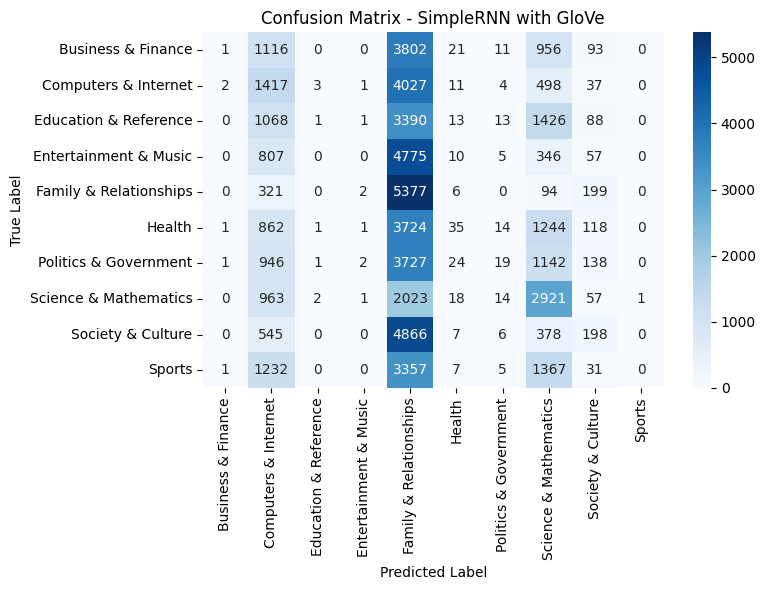

In [ ]:
print("Training GloVe + SimpleRNN...")

model_glove_rnn = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=False),
    SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_glove_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_glove_rnn = model_glove_rnn.fit(
    X_train_padded, y_train_cat,
    validation_data=(X_val_padded, y_val_cat),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

evaluate_model(model_glove_rnn, X_test, y_test_encoded, 'SimpleRNN', 'GloVe',
               tokenizer=tokenizer, is_neural=True)

### GloVe + LSTM

Training GloVe + LSTM...
Epoch 1/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 487s 137ms/step - accuracy: 0.1372 - loss: 2.2605 - val_accuracy: 0.2624 - val_loss: 1.9809
Epoch 2/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 498s 136ms/step - accuracy: 0.3204 - loss: 1.8942 - val_accuracy: 0.5062 - val_loss: 1.4863
Epoch 3/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 464s 132ms/step - accuracy: 0.4844 - loss: 1.5755 - val_accuracy: 0.5625 - val_loss: 1.3596
Epoch 4/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 507s 134ms/step - accuracy: 0.5374 - loss: 1.4557 - val_accuracy: 0.5841 - val_loss: 1.3029
Epoch 5/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 522s 140ms/step - accuracy: 0.5596 - loss: 1.3994 - val_accuracy: 0.5929 - val_loss: 1.2706
Epoch 6/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 473s 131ms/step - accuracy: 0.5704 - loss: 1.3651 - val_accuracy: 0.5998 - val_loss: 1.2454
Epoch 7/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 456s 130ms/step - accuracy: 0.5755 - loss: 1.3457 - val_accuracy: 0.6024 - val_loss: 1.2367
Epoch 8/15
3500/3500 ━━━━━━━━━━━━━━━━

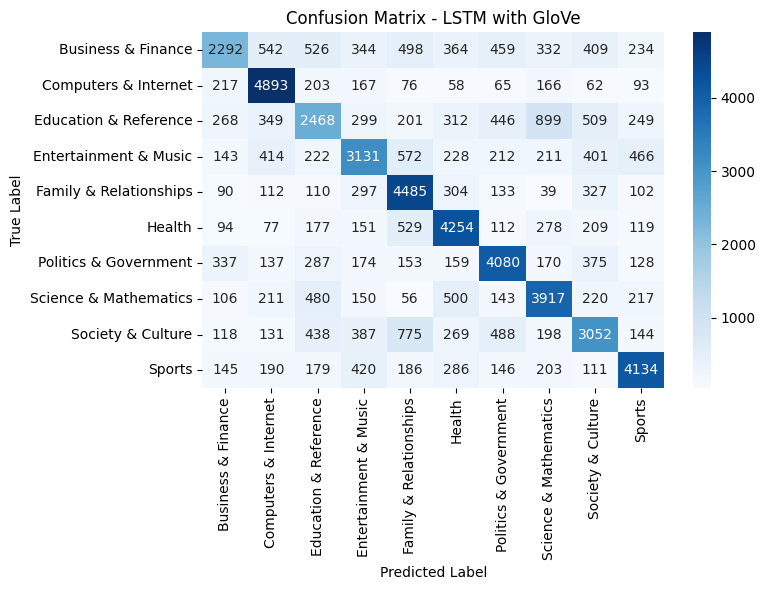

In [ ]:
print("Training GloVe + LSTM...")

model_glove_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=False),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_glove_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_glove_lstm = model_glove_lstm.fit(
    X_train_padded, y_train_cat,
    validation_data=(X_val_padded, y_val_cat),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

evaluate_model(model_glove_lstm, X_test, y_test_encoded, 'LSTM', 'GloVe',
               tokenizer=tokenizer, is_neural=True)

### GloVe + GRU

Training GloVe + GRU...
Epoch 1/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 453s 128ms/step - accuracy: 0.1880 - loss: 2.1454 - val_accuracy: 0.5752 - val_loss: 1.3205
Epoch 2/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 527s 135ms/step - accuracy: 0.5500 - loss: 1.4171 - val_accuracy: 0.5937 - val_loss: 1.2566
Epoch 3/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 500s 134ms/step - accuracy: 0.5710 - loss: 1.3537 - val_accuracy: 0.5995 - val_loss: 1.2397
Epoch 4/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 451s 129ms/step - accuracy: 0.5792 - loss: 1.3319 - val_accuracy: 0.6035 - val_loss: 1.2264
Epoch 5/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 507s 130ms/step - accuracy: 0.5837 - loss: 1.3123 - val_accuracy: 0.6059 - val_loss: 1.2112
Epoch 6/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 445s 127ms/step - accuracy: 0.5885 - loss: 1.2967 - val_accuracy: 0.6075 - val_loss: 1.2082
Epoch 7/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 478s 137ms/step - accuracy: 0.5911 - loss: 1.2896 - val_accuracy: 0.6091 - val_loss: 1.2007
Epoch 8/15
3500/3500 ━━━━━━━━━━━━━━━━━

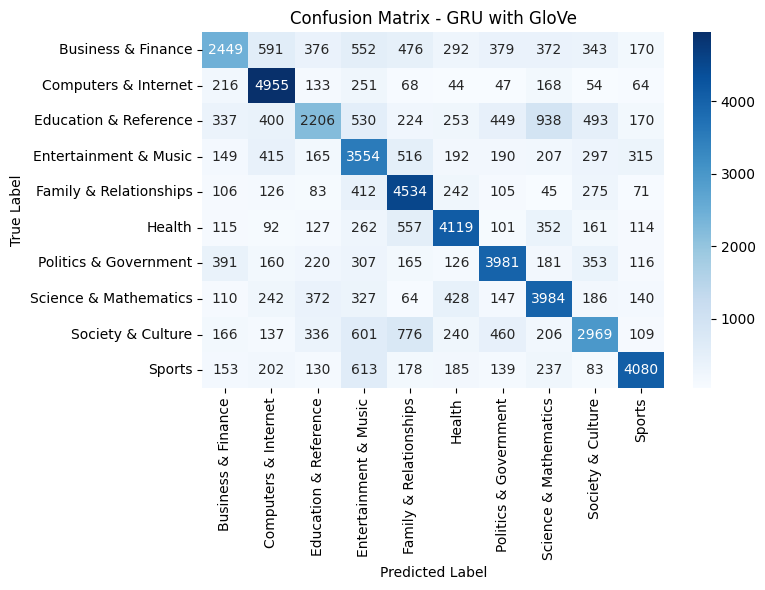

In [ ]:
print("Training GloVe + GRU...")

model_glove_gru = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=False),
    GRU(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_glove_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_glove_gru = model_glove_gru.fit(
    X_train_padded, y_train_cat,
    validation_data=(X_val_padded, y_val_cat),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

evaluate_model(model_glove_gru, X_test, y_test_encoded, 'GRU', 'GloVe',
               tokenizer=tokenizer, is_neural=True)

### GloVe + Bidirectional SimpleRNN

Training GloVe + Bidirectional SimpleRNN...
Epoch 1/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 191s 53ms/step - accuracy: 0.2501 - loss: 2.0913 - val_accuracy: 0.4449 - val_loss: 1.6944
Epoch 2/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 183s 52ms/step - accuracy: 0.3809 - loss: 1.8476 - val_accuracy: 0.4622 - val_loss: 1.6481
Epoch 3/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 205s 59ms/step - accuracy: 0.3944 - loss: 1.8230 - val_accuracy: 0.4581 - val_loss: 1.6670
Epoch 4/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 210s 60ms/step - accuracy: 0.3954 - loss: 1.8227 - val_accuracy: 0.4705 - val_loss: 1.6225
Epoch 5/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 175s 50ms/step - accuracy: 0.4049 - loss: 1.7967 - val_accuracy: 0.4743 - val_loss: 1.6198
Epoch 6/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 196s 48ms/step - accuracy: 0.4047 - loss: 1.8020 - val_accuracy: 0.4640 - val_loss: 1.6475
Epoch 7/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 175s 50ms/step - accuracy: 0.4042 - loss: 1.8063 - val_accuracy: 0.4574 - val_loss: 1.6534
Epoch 8/15
3500/3500 ━━━━

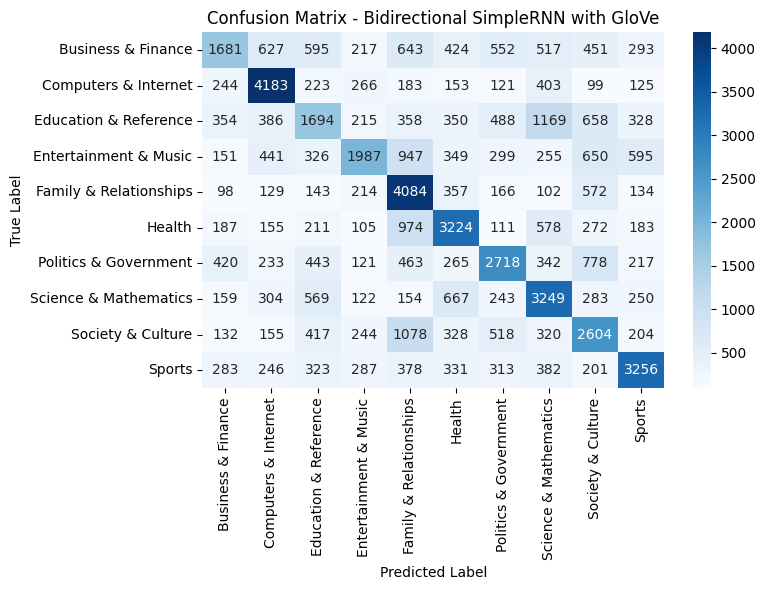

In [ ]:
print("Training GloVe + Bidirectional SimpleRNN...")

model_glove_bi_rnn = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=False),
    Bidirectional(SimpleRNN(32, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_glove_bi_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_glove_bi_rnn = model_glove_bi_rnn.fit(
    X_train_padded, y_train_cat,
    validation_data=(X_val_padded, y_val_cat),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

evaluate_model(model_glove_bi_rnn, X_test, y_test_encoded, 'Bidirectional SimpleRNN', 'GloVe',
               tokenizer=tokenizer, is_neural=True)

### GloVe + Bidirectional LSTM

Training GloVe + Bidirectional LSTM...
Epoch 1/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 654s 183ms/step - accuracy: 0.4514 - loss: 1.6525 - val_accuracy: 0.5888 - val_loss: 1.2734
Epoch 2/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 615s 176ms/step - accuracy: 0.5664 - loss: 1.3686 - val_accuracy: 0.5972 - val_loss: 1.2425
Epoch 3/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 631s 178ms/step - accuracy: 0.5779 - loss: 1.3322 - val_accuracy: 0.6007 - val_loss: 1.2286
Epoch 4/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 628s 179ms/step - accuracy: 0.5837 - loss: 1.3127 - val_accuracy: 0.6007 - val_loss: 1.2234
Epoch 5/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 617s 176ms/step - accuracy: 0.5847 - loss: 1.3096 - val_accuracy: 0.6037 - val_loss: 1.2173
Epoch 6/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 634s 181ms/step - accuracy: 0.5875 - loss: 1.3000 - val_accuracy: 0.6057 - val_loss: 1.2119
Epoch 7/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 624s 178ms/step - accuracy: 0.5905 - loss: 1.2921 - val_accuracy: 0.6049 - val_loss: 1.2109
Epoch 8/15
3500/3500 ━━

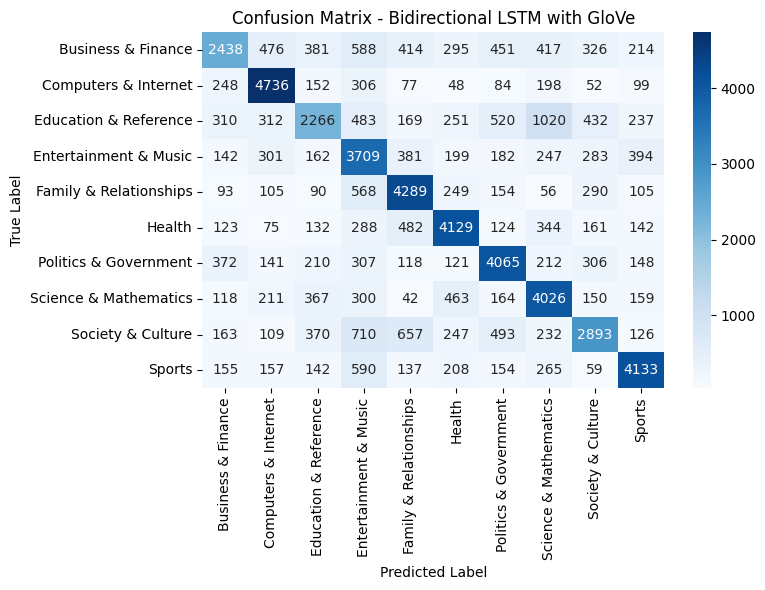

In [ ]:
print("Training GloVe + Bidirectional LSTM...")

model_glove_bi_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=False),
    Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_glove_bi_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_glove_bi_lstm = model_glove_bi_lstm.fit(
    X_train_padded, y_train_cat,
    validation_data=(X_val_padded, y_val_cat),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

evaluate_model(model_glove_bi_lstm, X_test, y_test_encoded, 'Bidirectional LSTM', 'GloVe',
               tokenizer=tokenizer, is_neural=True)

### GloVe + Bidirectional GRU

Training GloVe + Bidirectional GRU...
Epoch 1/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 652s 184ms/step - accuracy: 0.4331 - loss: 1.6849 - val_accuracy: 0.5874 - val_loss: 1.2773
Epoch 2/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 628s 179ms/step - accuracy: 0.5632 - loss: 1.3733 - val_accuracy: 0.5942 - val_loss: 1.2519
Epoch 3/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 645s 184ms/step - accuracy: 0.5737 - loss: 1.3457 - val_accuracy: 0.5990 - val_loss: 1.2346
Epoch 4/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 646s 185ms/step - accuracy: 0.5790 - loss: 1.3228 - val_accuracy: 0.6024 - val_loss: 1.2241
Epoch 5/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 671s 181ms/step - accuracy: 0.5835 - loss: 1.3109 - val_accuracy: 0.6038 - val_loss: 1.2201
Epoch 6/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 628s 179ms/step - accuracy: 0.5835 - loss: 1.3073 - val_accuracy: 0.6033 - val_loss: 1.2185
Epoch 7/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 648s 185ms/step - accuracy: 0.5846 - loss: 1.3034 - val_accuracy: 0.6049 - val_loss: 1.2156
Epoch 8/15
3500/3500 ━━━

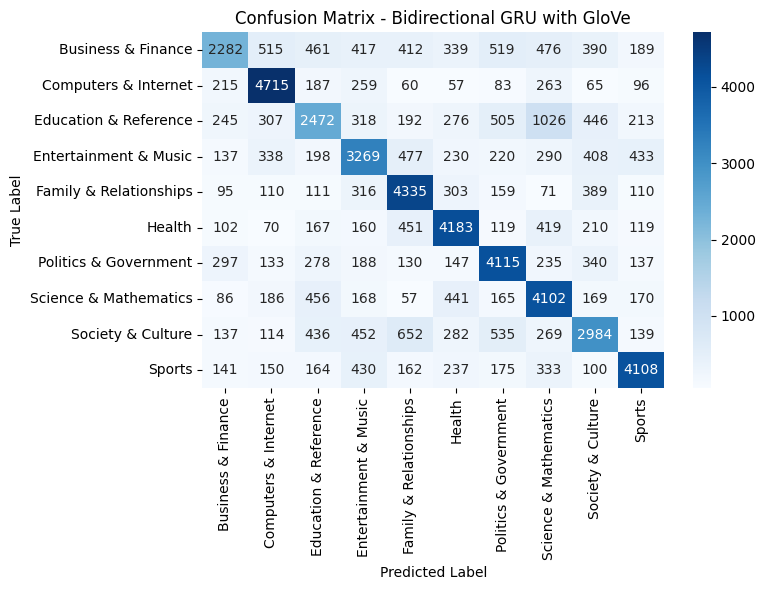

In [ ]:
print("Training GloVe + Bidirectional GRU...")

model_glove_bi_gru = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=False),
    Bidirectional(GRU(32, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_glove_bi_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_glove_bi_gru = model_glove_bi_gru.fit(
    X_train_padded, y_train_cat,
    validation_data=(X_val_padded, y_val_cat),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

evaluate_model(model_glove_bi_gru, X_test, y_test_encoded, 'Bidirectional GRU', 'GloVe',
               tokenizer=tokenizer, is_neural=True)

## Skip-Gram Implementations

In [ ]:
print("Training Skip-gram model...")

# Prepare text data for Word2Vec training
# Convert text back to list of words for Word2Vec
sentences = [text.split() for text in X_train]

# Train Word2Vec model with skip-gram architecture
# window=5: context window size (5 words before and after target word)
# workers=4: number of CPU cores to use
# sg=1: use skip-gram (sg=0 would be CBOW)
skipgram_model = Word2Vec(sentences=sentences, vector_size=50, window=5, workers=4, sg=1, epochs=5)

print(f"Skip-gram vocabulary size: {len(skipgram_model.wv.key_to_index)}")


skipgram_embedding_matrix = np.zeros((vocab_size, 50))

# Fill matrix with skip-gram vectors
words_found = 0
for word, i in tokenizer.word_index.items():
    if word in skipgram_model.wv:
        skipgram_embedding_matrix[i] = skipgram_model.wv[word]
        words_found += 1

print(f"Words found in Skip-gram model: {words_found}/{vocab_size}")

Training Skip-gram model...
Skip-gram vocabulary size: 59115
Words found in Skip-gram model: 59032/631262


### Skip-gram + Deep Neural Network

Training Skip-gram + Deep Neural Network...
Epoch 1/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.4135 - loss: 1.8456 - val_accuracy: 0.5682 - val_loss: 1.3863
Epoch 2/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.5474 - loss: 1.4157 - val_accuracy: 0.5797 - val_loss: 1.3229
Epoch 3/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.5649 - loss: 1.3613 - val_accuracy: 0.5827 - val_loss: 1.2997
Epoch 4/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5695 - loss: 1.3432 - val_accuracy: 0.5863 - val_loss: 1.2866
Epoch 5/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5723 - loss: 1.3363 - val_accuracy: 0.5871 - val_loss: 1.2803
Epoch 6/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.5740 - loss: 1.3260 - val_accuracy: 0.5878 - val_loss: 1.2726
Epoch 7/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.5768 - loss: 1.3188 - val_accuracy: 0.5897 - val_loss: 1.2693
Epoch 8/15
3500/3500 ━━━━━━━━━━━━━━━━━━

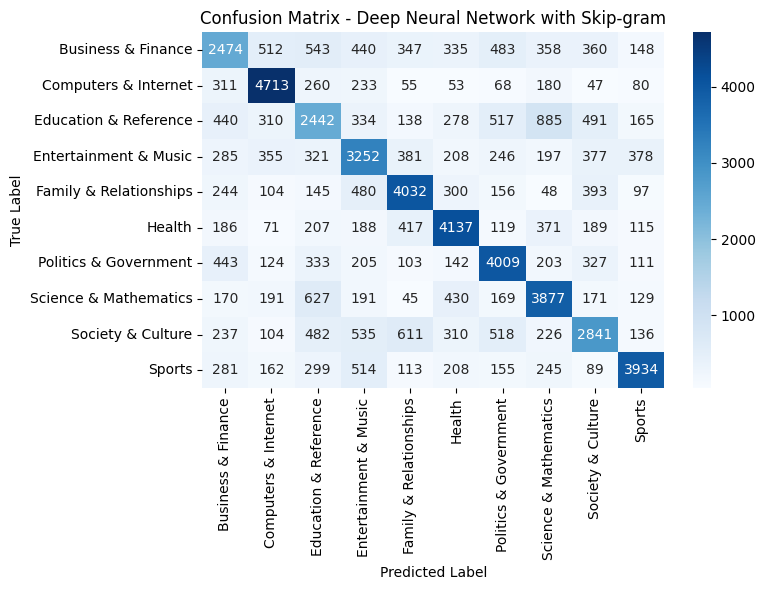

In [ ]:
print("Training Skip-gram + Deep Neural Network...")

with tf.device('/GPU:0'):
  model_skipgram_dnn = Sequential([
      Embedding(vocab_size, 50, weights=[skipgram_embedding_matrix],
                input_length=max_length, trainable=False),

      # Global average pooling to convert sequences to fixed-size vectors
      tf.keras.layers.GlobalAveragePooling1D(),

      Dense(64, activation='relu'),
      Dropout(0.3),
      Dense(num_classes, activation='softmax')
  ])

  # Compile model
  model_skipgram_dnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  history_skipgram_dnn = model_skipgram_dnn.fit(
      X_train_padded, y_train_cat,
      validation_data=(X_val_padded, y_val_cat),
      epochs=15,
      batch_size=64,
      callbacks=[early_stopping],
      verbose=1
  )

  # Evaluate performance
  evaluate_model(model_skipgram_dnn, X_test, y_test_encoded, 'Deep Neural Network', 'Skip-gram',
               tokenizer=tokenizer, is_neural=True)

### Skip-gram + SimpleRNN

Training Skip-gram + SimpleRNN...
Epoch 1/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 120s 34ms/step - accuracy: 0.1010 - loss: 2.3232 - val_accuracy: 0.0996 - val_loss: 2.3019
Epoch 2/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 118s 34ms/step - accuracy: 0.1011 - loss: 2.3015 - val_accuracy: 0.1031 - val_loss: 2.3002
Epoch 3/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 117s 33ms/step - accuracy: 0.1018 - loss: 2.3004 - val_accuracy: 0.1052 - val_loss: 2.2983
Epoch 4/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 117s 33ms/step - accuracy: 0.1052 - loss: 2.2992 - val_accuracy: 0.1049 - val_loss: 2.2971
Epoch 5/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 119s 34ms/step - accuracy: 0.1057 - loss: 2.2979 - val_accuracy: 0.1546 - val_loss: 2.2690
Epoch 6/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 118s 34ms/step - accuracy: 0.1112 - loss: 2.2942 - val_accuracy: 0.1136 - val_loss: 2.2822
Epoch 7/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 117s 34ms/step - accuracy: 0.1422 - loss: 2.2566 - val_accuracy: 0.1929 - val_loss: 2.1576
Epoch 8/15
3500/3500 ━━━━━━━━━━━━━━

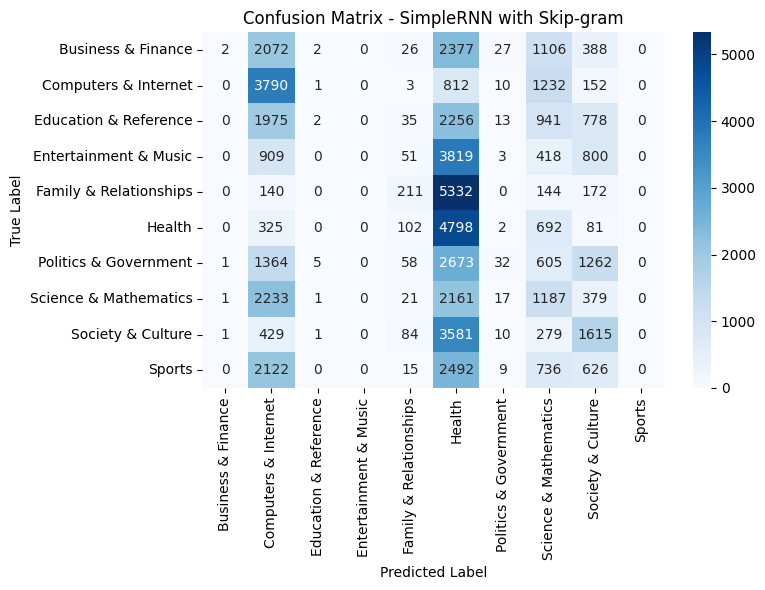

In [ ]:
print("Training Skip-gram + SimpleRNN...")

model_skipgram_rnn = Sequential([
    Embedding(vocab_size, 50, weights=[skipgram_embedding_matrix],
              input_length=max_length, trainable=False),

    SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2),

    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile model
model_skipgram_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_skipgram_rnn = model_skipgram_rnn.fit(
    X_train_padded, y_train_cat,
    validation_data=(X_val_padded, y_val_cat),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate performance
evaluate_model(model_skipgram_rnn, X_test, y_test_encoded, 'SimpleRNN', 'Skip-gram',
               tokenizer=tokenizer, is_neural=True)

### Skip-gram + LSTM

Training Skip-gram + LSTM...
Epoch 1/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 482s 136ms/step - accuracy: 0.1290 - loss: 2.2681 - val_accuracy: 0.3431 - val_loss: 1.7949
Epoch 2/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 501s 136ms/step - accuracy: 0.3556 - loss: 1.8124 - val_accuracy: 0.5515 - val_loss: 1.3847
Epoch 3/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 458s 131ms/step - accuracy: 0.5174 - loss: 1.5025 - val_accuracy: 0.5781 - val_loss: 1.3205
Epoch 4/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 526s 138ms/step - accuracy: 0.5415 - loss: 1.4419 - val_accuracy: 0.5842 - val_loss: 1.3019
Epoch 5/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 478s 131ms/step - accuracy: 0.5552 - loss: 1.4103 - val_accuracy: 0.5922 - val_loss: 1.2765
Epoch 6/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 461s 132ms/step - accuracy: 0.5640 - loss: 1.3846 - val_accuracy: 0.5965 - val_loss: 1.2604
Epoch 7/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 459s 131ms/step - accuracy: 0.5708 - loss: 1.3665 - val_accuracy: 0.5984 - val_loss: 1.2444
Epoch 8/15
3500/3500 ━━━━━━━━━━━━

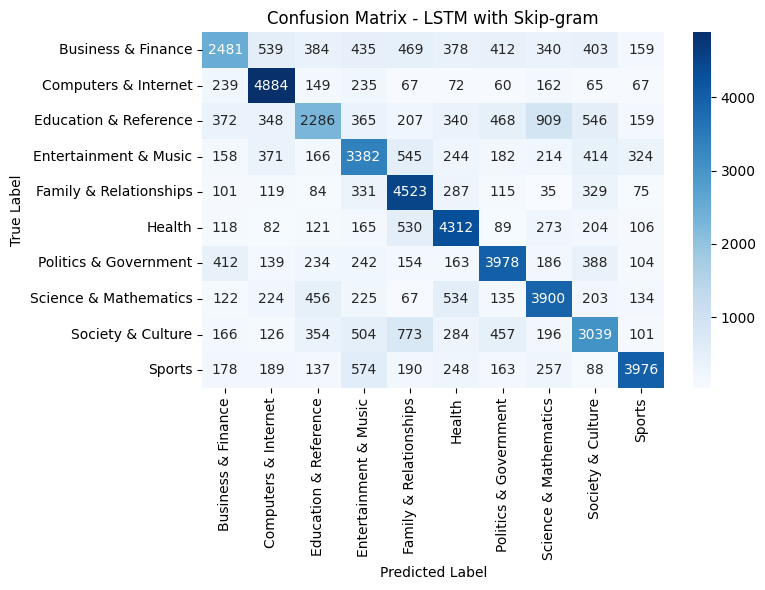

In [ ]:
print("Training Skip-gram + LSTM...")

with tf.device('/GPU:0'):
  model_skipgram_lstm = Sequential([
      Embedding(vocab_size, 50, weights=[skipgram_embedding_matrix],
                input_length=max_length, trainable=False),

      LSTM(64, dropout=0.2, recurrent_dropout=0.2),

      Dense(32, activation='relu'),
      Dropout(0.3),
      Dense(num_classes, activation='softmax')
  ])

  # Compile model
  model_skipgram_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Train the model
  history_skipgram_lstm = model_skipgram_lstm.fit(
      X_train_padded, y_train_cat,
      validation_data=(X_val_padded, y_val_cat),
      epochs=15,
      batch_size=64,
      callbacks=[early_stopping],
      verbose=1
  )

  # Evaluate performance
  evaluate_model(model_skipgram_lstm, X_test, y_test_encoded, 'LSTM', 'Skip-gram',
               tokenizer=tokenizer, is_neural=True)

### Skip-gram + GRU

Training Skip-gram + GRU...
Epoch 1/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 432s 120ms/step - accuracy: 0.1361 - loss: 2.2450 - val_accuracy: 0.5644 - val_loss: 1.3596
Epoch 2/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 424s 121ms/step - accuracy: 0.5376 - loss: 1.4496 - val_accuracy: 0.5928 - val_loss: 1.2602
Epoch 3/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 447s 123ms/step - accuracy: 0.5643 - loss: 1.3726 - val_accuracy: 0.5991 - val_loss: 1.2382
Epoch 4/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 433s 120ms/step - accuracy: 0.5764 - loss: 1.3355 - val_accuracy: 0.6021 - val_loss: 1.2233
Epoch 5/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 428s 122ms/step - accuracy: 0.5809 - loss: 1.3212 - val_accuracy: 0.6049 - val_loss: 1.2136
Epoch 6/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 439s 121ms/step - accuracy: 0.5856 - loss: 1.3105 - val_accuracy: 0.6048 - val_loss: 1.2133
Epoch 7/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 436s 125ms/step - accuracy: 0.5890 - loss: 1.2971 - val_accuracy: 0.6084 - val_loss: 1.2012
Epoch 8/15
3500/3500 ━━━━━━━━━━━━━

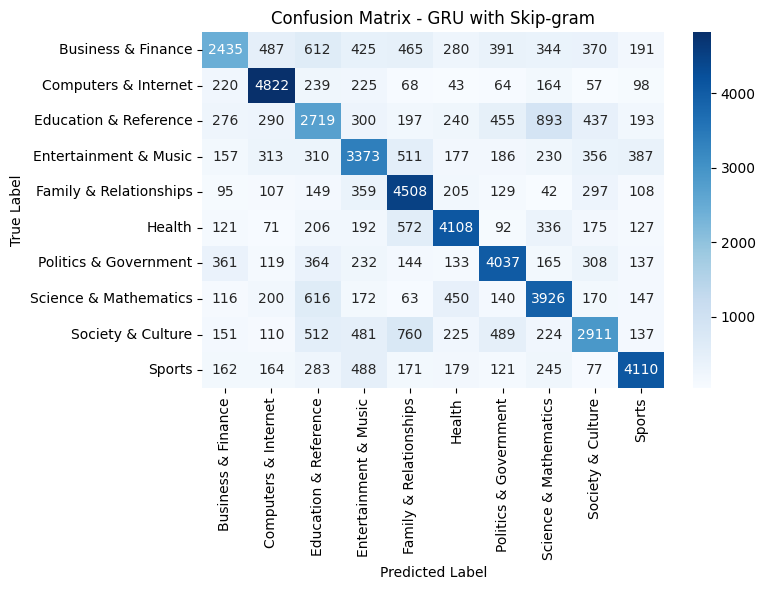

In [ ]:
print("Training Skip-gram + GRU...")

with tf.device('/GPU:0'):
  model_skipgram_gru = Sequential([
      Embedding(vocab_size, 50, weights=[skipgram_embedding_matrix],
                input_length=max_length, trainable=False),

      GRU(64, dropout=0.2, recurrent_dropout=0.2),

      Dense(32, activation='relu'),
      Dropout(0.3),
      Dense(num_classes, activation='softmax')
  ])

  # Compile model
  model_skipgram_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Train the model
  history_skipgram_gru = model_skipgram_gru.fit(
      X_train_padded, y_train_cat,
      validation_data=(X_val_padded, y_val_cat),
      epochs=15,
      batch_size=64,
      callbacks=[early_stopping],
      verbose=1
  )

  # Evaluate performance
  evaluate_model(model_skipgram_gru, X_test, y_test_encoded, 'GRU', 'Skip-gram',
               tokenizer=tokenizer, is_neural=True)

### Skip-gram + Bidirectional SimpleRNN

Training Skip-gram + Bidirectional SimpleRNN...
Epoch 1/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 170s 47ms/step - accuracy: 0.2739 - loss: 2.0456 - val_accuracy: 0.4640 - val_loss: 1.6188
Epoch 2/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 174s 50ms/step - accuracy: 0.3973 - loss: 1.8009 - val_accuracy: 0.4759 - val_loss: 1.6029
Epoch 3/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 162s 46ms/step - accuracy: 0.4079 - loss: 1.7799 - val_accuracy: 0.4853 - val_loss: 1.5840
Epoch 4/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 203s 47ms/step - accuracy: 0.4102 - loss: 1.7781 - val_accuracy: 0.4701 - val_loss: 1.6273
Epoch 5/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 163s 46ms/step - accuracy: 0.4061 - loss: 1.7865 - val_accuracy: 0.4802 - val_loss: 1.5950
Epoch 6/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 164s 47ms/step - accuracy: 0.4147 - loss: 1.7691 - val_accuracy: 0.5061 - val_loss: 1.5355
Epoch 7/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 203s 47ms/step - accuracy: 0.4201 - loss: 1.7586 - val_accuracy: 0.4990 - val_loss: 1.5570
Epoch 8/15
3500/3500 

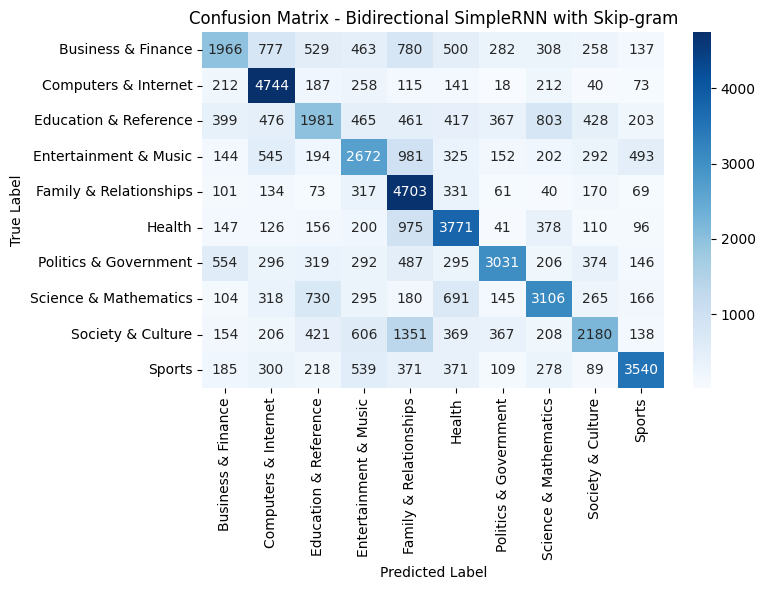

In [ ]:
print("Training Skip-gram + Bidirectional SimpleRNN...")

with tf.device('/GPU:0'):
  model_skipgram_bi_rnn = Sequential([
      Embedding(vocab_size, 50, weights=[skipgram_embedding_matrix],
                input_length=max_length, trainable=False),

      Bidirectional(SimpleRNN(32, dropout=0.2, recurrent_dropout=0.2)),

      Dense(32, activation='relu'),
      Dropout(0.3),
      Dense(num_classes, activation='softmax')
  ])

  # Compile model
  model_skipgram_bi_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Train the model
  history_skipgram_bi_rnn = model_skipgram_bi_rnn.fit(
      X_train_padded, y_train_cat,
      validation_data=(X_val_padded, y_val_cat),
      epochs=15,
      batch_size=64,
      callbacks=[early_stopping],
      verbose=1
  )

  # Evaluate performance
  evaluate_model(model_skipgram_bi_rnn, X_test, y_test_encoded, 'Bidirectional SimpleRNN', 'Skip-gram',
               tokenizer=tokenizer, is_neural=True)

### Skip-gram + Bidirectional LSTM

Training Skip-gram + Bidirectional LSTM...
Epoch 1/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 681s 192ms/step - accuracy: 0.4400 - loss: 1.6759 - val_accuracy: 0.5942 - val_loss: 1.2629
Epoch 2/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 663s 189ms/step - accuracy: 0.5689 - loss: 1.3662 - val_accuracy: 0.6004 - val_loss: 1.2364
Epoch 3/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 682s 189ms/step - accuracy: 0.5787 - loss: 1.3363 - val_accuracy: 0.6014 - val_loss: 1.2265
Epoch 4/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 689s 191ms/step - accuracy: 0.5853 - loss: 1.3141 - val_accuracy: 0.6037 - val_loss: 1.2190
Epoch 5/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 680s 191ms/step - accuracy: 0.5844 - loss: 1.3129 - val_accuracy: 0.6045 - val_loss: 1.2126
Epoch 6/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 671s 192ms/step - accuracy: 0.5884 - loss: 1.3014 - val_accuracy: 0.6064 - val_loss: 1.2070
Epoch 7/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 682s 191ms/step - accuracy: 0.5878 - loss: 1.3031 - val_accuracy: 0.6056 - val_loss: 1.2067
Epoch 8/15
3500/350

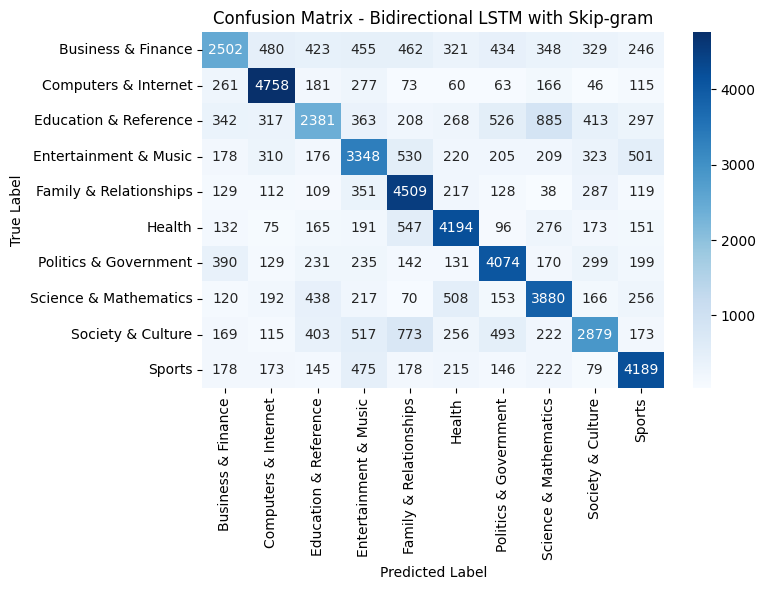

In [ ]:
print("Training Skip-gram + Bidirectional LSTM...")

with tf.device('/GPU:0'):
  model_skipgram_bi_lstm = Sequential([
      Embedding(vocab_size, 50, weights=[skipgram_embedding_matrix],
                input_length=max_length, trainable=False),

      Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),

      Dense(32, activation='relu'),
      Dropout(0.3),
      Dense(num_classes, activation='softmax')
  ])

  # Compile model
  model_skipgram_bi_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Train the model
  history_skipgram_bi_lstm = model_skipgram_bi_lstm.fit(
      X_train_padded, y_train_cat,
      validation_data=(X_val_padded, y_val_cat),
      epochs=15,
      batch_size=64,
      callbacks=[early_stopping],
      verbose=1
  )

  # Evaluate performance
  evaluate_model(model_skipgram_bi_lstm, X_test, y_test_encoded, 'Bidirectional LSTM', 'Skip-gram',
               tokenizer=tokenizer, is_neural=True)

### Skip-gram + Bidirectional GRU

Training Skip-gram + Bidirectional GRU...
Epoch 1/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 615s 173ms/step - accuracy: 0.4349 - loss: 1.6811 - val_accuracy: 0.5907 - val_loss: 1.2719
Epoch 2/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 621s 173ms/step - accuracy: 0.5628 - loss: 1.3781 - val_accuracy: 0.5973 - val_loss: 1.2428
Epoch 3/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 617s 176ms/step - accuracy: 0.5733 - loss: 1.3473 - val_accuracy: 0.6002 - val_loss: 1.2302
Epoch 4/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 604s 173ms/step - accuracy: 0.5784 - loss: 1.3305 - val_accuracy: 0.6028 - val_loss: 1.2200
Epoch 5/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 607s 173ms/step - accuracy: 0.5793 - loss: 1.3229 - val_accuracy: 0.6033 - val_loss: 1.2166
Epoch 6/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 606s 173ms/step - accuracy: 0.5841 - loss: 1.3111 - val_accuracy: 0.6044 - val_loss: 1.2153
Epoch 7/15
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 636s 177ms/step - accuracy: 0.5851 - loss: 1.3055 - val_accuracy: 0.6050 - val_loss: 1.2111
Epoch 8/15
3500/3500

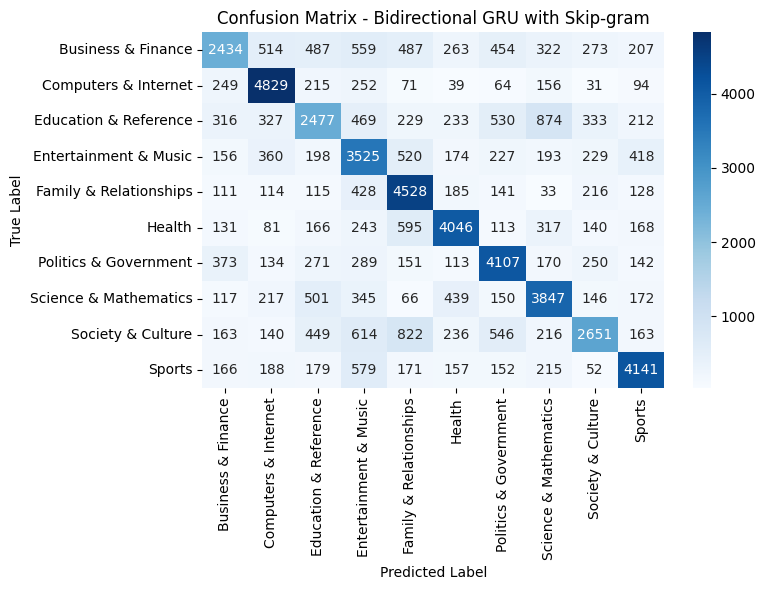

In [ ]:
print("Training Skip-gram + Bidirectional GRU...")

with tf.device('/GPU:0'):
  model_skipgram_bi_gru = Sequential([
      Embedding(vocab_size, 50, weights=[skipgram_embedding_matrix],
                input_length=max_length, trainable=False),

      Bidirectional(GRU(32, dropout=0.2, recurrent_dropout=0.2)),

      Dense(32, activation='relu'),
      Dropout(0.3),
      Dense(num_classes, activation='softmax')
  ])

  # Compile model
  model_skipgram_bi_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Train the model
  history_skipgram_bi_gru = model_skipgram_bi_gru.fit(
      X_train_padded, y_train_cat,
      validation_data=(X_val_padded, y_val_cat),
      epochs=15,
      batch_size=64,
      callbacks=[early_stopping],
      verbose=1
  )

  # Evaluate performance
  evaluate_model(model_skipgram_bi_gru, X_test, y_test_encoded, 'Bidirectional GRU', 'Skip-gram',
               tokenizer=tokenizer, is_neural=True)

# Comparison and Evaluation

MODEL PERFORMANCE ANALYSIS

ALL RESULTS (Sorted by Accuracy):
                  model  features  accuracy  f1_macro  f1_weighted
    Logistic Regression    TF-IDF  0.689378  0.687072     0.687072
            Naive Bayes    TF-IDF  0.676678  0.673841     0.673841
            Naive Bayes       BoW  0.670611  0.667855     0.667854
    Logistic Regression       BoW  0.635944  0.634017     0.634017
                    GRU Skip-gram  0.615827  0.611883     0.611882
    Deep Neural Network    TF-IDF  0.614994  0.609559     0.609558
                    GRU     GloVe  0.613860  0.607798     0.607797
                   LSTM Skip-gram  0.612694  0.606817     0.606816
     Bidirectional LSTM Skip-gram  0.611910  0.605830     0.605828
                   LSTM     GloVe  0.611777  0.605041     0.605040
    Deep Neural Network       BoW  0.611477  0.607283     0.607282
     Bidirectional LSTM     GloVe  0.611410  0.606143     0.606142
      Bidirectional GRU Skip-gram  0.609760  0.604197     0.604196


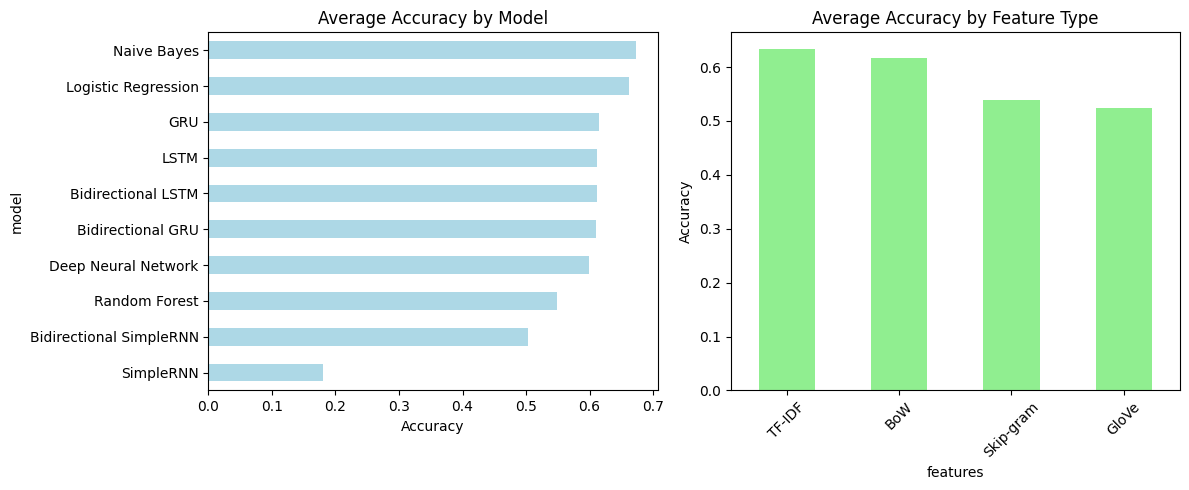


Summary: 22 total experiments completed


In [27]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# Load all results
results = joblib.load(results_file)
results_df = pd.DataFrame(results)

print("="*60)
print("MODEL PERFORMANCE ANALYSIS")
print("="*60)

# Display all results sorted by accuracy
print("\nALL RESULTS (Sorted by Accuracy):")
display_df = results_df.sort_values('accuracy', ascending=False)
print(display_df[['model', 'features', 'accuracy', 'f1_macro', 'f1_weighted']].to_string(index=False))

# Separate ML and NN models
ml_models = ['Random Forest', 'Logistic Regression', 'Naive Bayes']
nn_models = ['Deep Neural Network', 'SimpleRNN', 'LSTM', 'GRU',
             'Bidirectional SimpleRNN', 'Bidirectional LSTM', 'Bidirectional GRU']

ml_results = results_df[results_df['model'].isin(ml_models)]
nn_results = results_df[results_df['model'].isin(nn_models)]

# Find best and worst models
best_overall = results_df.loc[results_df['accuracy'].idxmax()]
worst_overall = results_df.loc[results_df['accuracy'].idxmin()]

print(f"\n🏆 BEST OVERALL: {best_overall['model']} with {best_overall['features']}")
print(f"   Accuracy: {best_overall['accuracy']:.4f}, F1-Macro: {best_overall['f1_macro']:.4f}")

print(f"\n❌ WORST OVERALL: {worst_overall['model']} with {worst_overall['features']}")
print(f"   Accuracy: {worst_overall['accuracy']:.4f}, F1-Macro: {worst_overall['f1_macro']:.4f}")

# Best ML and NN models
if len(ml_results) > 0:
    best_ml = ml_results.loc[ml_results['accuracy'].idxmax()]
    print(f"\n🤖 BEST ML MODEL: {best_ml['model']} with {best_ml['features']}")
    print(f"   Accuracy: {best_ml['accuracy']:.4f}, F1-Macro: {best_ml['f1_macro']:.4f}")

if len(nn_results) > 0:
    best_nn = nn_results.loc[nn_results['accuracy'].idxmax()]
    print(f"\n🧠 BEST NN MODEL: {best_nn['model']} with {best_nn['features']}")
    print(f"   Accuracy: {best_nn['accuracy']:.4f}, F1-Macro: {best_nn['f1_macro']:.4f}")

# Detailed comparison between best ML and best NN
if len(ml_results) > 0 and len(nn_results) > 0:
    print(f"\n" + "="*60)
    print("BEST ML vs BEST NN COMPARISON")
    print("="*60)

    acc_diff = best_nn['accuracy'] - best_ml['accuracy']
    f1_diff = best_nn['f1_macro'] - best_ml['f1_macro']

    print(f"ML Model:  {best_ml['model']} ({best_ml['features']})")
    print(f"NN Model:  {best_nn['model']} ({best_nn['features']})")
    print(f"Accuracy Difference: {acc_diff:+.4f} (NN - ML)")
    print(f"F1-Macro Difference: {f1_diff:+.4f} (NN - ML)")

    if acc_diff > 0:
        print(f"🏆 Winner: Neural Network by {acc_diff:.4f} accuracy points")
    else:
        print(f"🏆 Winner: Machine Learning by {abs(acc_diff):.4f} accuracy points")
    print()

# Simple visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Model comparison
model_avg = results_df.groupby('model')['accuracy'].mean().sort_values(ascending=True)
model_avg.plot(kind='barh', ax=ax1, color='lightblue')
ax1.set_title('Average Accuracy by Model')
ax1.set_xlabel('Accuracy')

# Feature comparison
feature_avg = results_df.groupby('features')['accuracy'].mean().sort_values(ascending=False)
feature_avg.plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Average Accuracy by Feature Type')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nSummary: {len(results_df)} total experiments completed")